In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
data_folder = '../../data/'
affiliations = pd.read_csv(data_folder + 'affiliations_coded.csv')
papers = pd.read_csv(data_folder + 'papers_all_df.csv')

In [3]:
affiliations_not_na = affiliations[~affiliations['affiliation_type_full'].isna()]

In [4]:
affiliations_not_na.affiliation_type_full.value_counts()

Academic                   303
For-profit corporation     149
Non-profit organization     29
Government                   5
Undetermined                 3
Name: affiliation_type_full, dtype: int64

In [5]:
print(affiliations_not_na.columns)
print(papers.columns)

Index(['Unnamed: 0', 'paper_id', 'author_name', 'author_affiliation',
       'authorId', 'affiliation_type_auto', 'affiliation_type_full'],
      dtype='object')
Index(['Unnamed: 0', 'paperId', 'url', 'title', 'citationCount',
       'influentialCitationCount', 'year'],
      dtype='object')


In [6]:
affiliations_not_na.paper_id

76      6226e7dcee9e050face0caf852de37a9c2937812
84      d20744d41de25c3181f3b3fcb749531a6ec9e76d
93      beb1226c89615d2b092b9230c4df5c496a2a76eb
150     317cde2189509f8fd314304aa2f821f1b62ff81f
172     6586832314622af008c217a20a27bae9dc8d85fc
                          ...                   
4338    5d22b241836e30d5b0d852b463951ab7e3245ea4
4358    68f141724814839d556a989646194be88641b143
4365    26e3d58181724f9ef77973ff0f65bac06e499fec
4369    bd0a48959b14ad942046c24ee7e7225450b90914
4371    ef2d4dac9c0b2919737af9c0b087e793cc438a7e
Name: paper_id, Length: 489, dtype: object

In [7]:
papers.paperId

0      2ef9abf5245f8abb1dd05896a23b8885ce562b90
1      4748fcfb83d8da742406d8606e31dc5710e8b09c
2      8c8690406427e651503da0b07d293e91e6fa6e42
3      fbdada9261955f0820a4e3c0637bb4eb197b5268
4      04b1e6e0e38e2f707ad73b736e94b1d1b25186a1
                         ...                   
995    e70b7eb3b22f0a49eb5e645be646d5f35d1e693a
996    4b0ec90dc10e51c1fc983edcd57bb86636d7b3ca
997    a65b7ff72deb358bef29900a53c814771275c37c
998    f659031ceb7bbdcb7b0690742f35e2924fd1ed75
999    fea02a76f504f6dfefd2497220da913c5274f5ab
Name: paperId, Length: 1000, dtype: object

In [8]:
#join affiliations and papers to get the year of affiliations
affiliations_w_years = affiliations.merge(papers, left_on='paper_id',right_on='paperId', how='left', suffixes=('_aff', '_paper'))

# #calculate the percentage of affiliations for each affiliation_type out of all the affiliations in that year
# affiliations_by_year = affiliations_w_years.groupby('year').affiliation_type_full.value_counts(normalize=True).unstack()

# #fill the NaNs with 0
# affiliations_by_year = affiliations_by_year.fillna(0)

In [9]:
#now encapsulate all that in a function that takes the table (or subtable) and returns the confidence intervals
def get_confidence_intervals(affiliations_w_years):
    #we need confidence intervals as well

    #the proper confidence intervals are going to be calculated using the binomial distribution

    #might be easiest to first write this for all years, then group by year and pass that function
    #get the proportion and SE of the proportion of each affiliation type
    aggregate_counts = (affiliations_w_years.groupby('affiliation_type_full').
        affiliation_type_full.
        value_counts().
        to_frame().
        rename(columns={'affiliation_type_full':'count'})
    )

    #drop the index level that is the same as the column
    aggregate_counts.index = aggregate_counts.index.droplevel(1)
    total_paper_count = sum(aggregate_counts['count'])
    aggregate_counts['proportion']=aggregate_counts['count']/total_paper_count
    aggregate_counts['proportion_se']=np.sqrt(aggregate_counts['proportion']*(1-aggregate_counts['proportion'])/total_paper_count)
    aggregate_counts['ci90_lower'] = aggregate_counts['proportion'] - 1.645*aggregate_counts['proportion_se']
    aggregate_counts['ci90_upper'] = aggregate_counts['proportion'] + 1.645*aggregate_counts['proportion_se']
    return(aggregate_counts)





In [10]:
get_confidence_intervals(affiliations_w_years)

,count,proportion,proportion_se,ci90_lower,ci90_upper
affiliation_type_full,,,,,
Academic,303,0.619632,0.021954,0.583518,0.655746
For-profit corporation,149,0.304703,0.020815,0.270463,0.338944
Government,5,0.010225,0.004549,0.002741,0.017709
Non-profit organization,29,0.059305,0.010681,0.041734,0.076875
Undetermined,3,0.006135,0.003531,0.000326,0.011944


In [12]:
#now we can calculate the confidence intervals for each year
prop_by_year = affiliations_w_years.groupby('year').apply(get_confidence_intervals)
prop_by_year.reset_index(inplace=True)
prop_by_year

,year,affiliation_type_full,count,proportion,proportion_se,ci90_lower,ci90_upper
0,2012,Academic,9,0.750000,0.125000,0.544375,0.955625
1,2012,For-profit corporation,3,0.250000,0.125000,0.044375,0.455625
2,2013,Academic,19,0.655172,0.088263,0.509979,0.800365
3,2013,For-profit corporation,7,0.241379,0.079463,0.110663,0.372095
4,2013,Non-profit organization,1,0.034483,0.033883,-0.021255,0.090220
5,2013,Undetermined,2,0.068966,0.047054,-0.008439,0.146370
6,2014,Academic,17,0.586207,0.091457,0.435760,0.736654
7,2014,For-profit corporation,9,0.310345,0.085909,0.169024,0.451665
8,2014,Government,2,0.068966,0.047054,-0.008439,0.146370
9,2014,Non-profit organization,1,0.034483,0.033883,-0.021255,0.090220


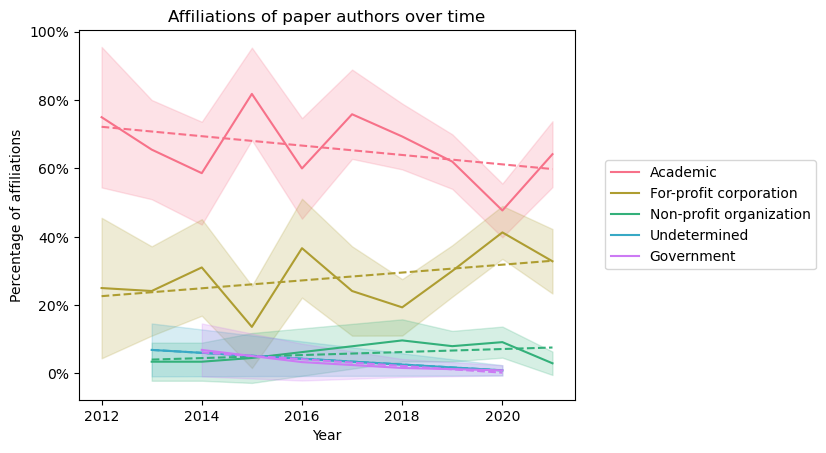

In [13]:
#now graph the proportions with the confidence intervals
#plot a line for each affiliation type
#put year on the x axis
#put proportion on the y axis
#put the confidence intervals on the y axis
#put the affiliation type on the legend
x_axis = prop_by_year.year
y_axis = prop_by_year.proportion
y_axis_lower = prop_by_year.ci90_lower
y_axis_upper = prop_by_year.ci90_upper
group = prop_by_year.affiliation_type_full
#plot a line for each group
#assign a color to each group
#use a different marker for each group
groups =group.unique()
colors = sns.color_palette("husl", len(groups))
for at_c, g in enumerate(groups):
    #create a trendline using polyfit for this group
    z=np.polyfit(x_axis[group==g], y_axis[group==g], 1)
    p=np.poly1d(z)
    plt.plot(x_axis[group==g], p(x_axis[group==g]), linestyle='dashed',color=colors[at_c])
    plt.plot(x_axis[group==g], y_axis[group==g], label=g,color=colors[at_c])
    plt.fill_between(x_axis[group==g], y_axis_lower[group==g], y_axis_upper[group==g], alpha=0.2,color=colors[at_c])#add a legend below the graph area
plt.legend(bbox_to_anchor=(1.5,0.5), loc='right')
plt.xlabel('Year')
plt.ylabel('Percentage of affiliations')
#show the y axis as a percentage
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:.0%}".format(x)))
#add title
plt.title('Affiliations of paper authors over time')
plt.show()


In [25]:
#Now, we should really test this to see whether the trend is significant. 
#Using a logistic regression model, does likelihood of being an academic paper decrease/being a for-profit paper increase over time?
#We can use the year as a continuous variable, and the affiliation type as a categorical variable


#do a logistic regression with statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
#add a constant to the model

#remove the rows where the affiliation type is NA
affiliations_w_years_not_na = affiliations_w_years[~affiliations_w_years['affiliation_type_full'].isna()].copy()
#first, we need to create a dummy variable for the affiliation type
affiliations_w_years_not_na['is_academic'] = affiliations_w_years_not_na['affiliation_type_full']=='Academic'
affiliations_w_years_not_na['is_forprofit'] = affiliations_w_years_not_na['affiliation_type_full']=='For-profit corporation'

# building the model and fitting the data
affiliations_w_years_not_na['const'] = 1
log_for_profit = sm.Logit(affiliations_w_years_not_na.is_forprofit, affiliations_w_years_not_na['const','year']]).fit()

print(log_for_profit.summary())


/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/statsmodels/base/data.py:697: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  exog = np.asarray(exog)


ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data). The types seen wereNone and None. The data was
76      False
84      False
93      False
150     False
172     False
        ...  
4338    False
4358    False
4365    False
4369    False
4371    False
Name: is_forprofit, Length: 489, dtype: bool
and
 [1 76      2012
   84      2012
   93      2012
   150     2012
   172     2012
           ...
   4338    2019
   4358    2021
   4365    2021
   4369    2021
   4371    2019
   Name: year, Length: 489, dtype: int64]
before. After,
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False  True False False False
  True False False False False False False False False False False  True
 False  True False False False  True False  True False False False False
 False False False False False False  True False False False False  True
  True False False False  True False  True False  True  True  True False
  True  True False False False False False False False]
[1 76      2012
   84      2012
   93      2012
   150     2012
   172     2012
           ...
   4338    2019
   4358    2021
   4365    2021
   4369    2021
   4371    2019
   Name: year, Length: 489, dtype: int64].

In [ ]:
affiliations_w_years_not_na['affiliation_type_full']=='Academic'

0       False
1       False
2       False
3       False
4       False
        ...  
4411    False
4412    False
4413    False
4414    False
4415    False
Name: affiliation_type_full, Length: 4416, dtype: bool

It's important to note these are proportions of authors where we had an affiliation indicated at all. Most authors in this survey (89%) had no affiliation recorded in semantic scholar.

In [ ]:
affiliations_w_years_with_nulls = affiliations_w_years
affiliations_w_years_with_nulls['affiliation_type_full'] = affiliations_w_years_with_nulls['affiliation_type_full'].fillna('Not indicated')
get_confidence_intervals(affiliations_w_years)

#now we can calculate the confidence intervals for each year
# prop_by_year_out_of_all = affiliations_w_years_with_nulls.groupby('year').apply(get_confidence_intervals)
# prop_by_year_out_of_all.reset_index(inplace=True)


,count,proportion,proportion_se,ci90_lower,ci90_upper
affiliation_type_full,,,,,
Academic,303,0.068614,0.003804,0.062356,0.074872
For-profit corporation,149,0.033741,0.002717,0.029271,0.038211
Government,5,0.001132,0.000506,0.000300,0.001965
Non-profit organization,29,0.006567,0.001215,0.004568,0.008566
Not indicated,3927,0.889266,0.004722,0.881498,0.897034
Undetermined,3,0.000679,0.000392,0.000034,0.001324
